In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import shap
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
from pygam import LinearGAM, s, f

# Step 1: Load the Dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, delimiter=";")

# Step 2: Train a Model
X = data.drop("quality", axis=1)
y = data['quality'].apply(lambda x: 1 if x >= 7 else 0)  # 标签二值化处理

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [2]:
import numpy as np
y_test = np.array(y_test)
pred = model.predict(X_train)
y_train= np.array(y_train)

k = 0
n=0
for i in range(len(pred)):
    if pred[i] == y_train[i]:
        k+=1
        if y_train[i]==1:
            # print(i)
            n+=1
print(k/len(pred))
print(n/len(pred))

1.0
0.13291634089132134


In [5]:
#Step 3: Apply LIME to Explain a Single Instance
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, 
                                                   feature_names=X.columns, 
                                                   class_names=['<7', '>=7'], 
                                                   discretize_continuous=True)


/mnt/ssd2/yifan/miniconda3/envs/llama/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


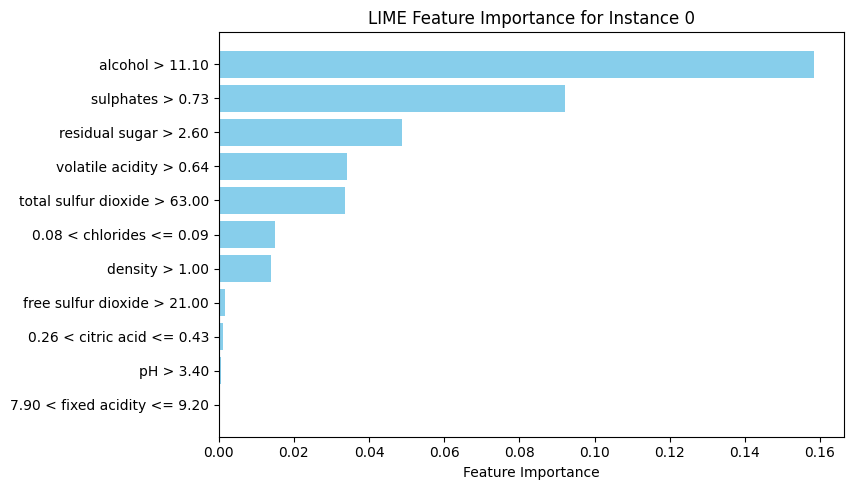

In [6]:
# Select an instance to explain
i = 0  # 选择第一个实例
instance = X_train.iloc[i]

# Generate explanation
exp = explainer.explain_instance(instance.values, model.predict_proba, num_features=len(X.columns))

# Extract feature importance (absolute values)
exp_dict = dict(exp.as_list())
features = list(exp_dict.keys())
importance = [abs(val) for val in exp_dict.values()]

# Step 4: Plot Feature Importance
plt.figure(figsize=(8, 5))
plt.barh(features, importance, color='skyblue')
plt.xlabel('Feature Importance')
plt.title('LIME Feature Importance for Instance {}'.format(i))
plt.gca().invert_yaxis()
plt.tight_layout()  # Adjust layout to ensure everything fits
plt.subplots_adjust(left=0.2)  # Adjust the left margin to fit long labels

plt.show()

/mnt/ssd2/yifan/miniconda3/envs/llama/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


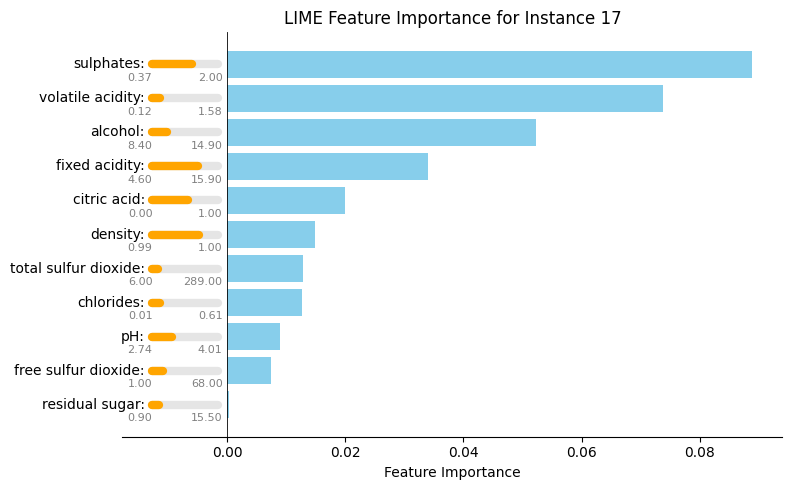

In [7]:
import re

from matplotlib.collections import LineCollection
import random
random_seed = 42
np.random.seed(random_seed)
random.seed(random_seed)

# Select an instance to explain
i = 17  # Choose the instance
instance = X_train.iloc[i]
# Generate explanation
exp = explainer.explain_instance(instance.values, model.predict_proba, num_features=len(X.columns))

# Extract feature importance (absolute values)
exp_dict = dict(exp.as_list())
features = list(exp_dict.keys())
org_importance = [abs(val) for val in exp_dict.values()]
# Convert feature values to strings
original_importance = {feature: abs(val) for feature, val in exp_dict.items()}

instance_str = instance.apply(lambda x: str(x))
original_instance_str = instance.apply(lambda x: str(x))

# Extract feature names and values using regular expressions
features_with_values = []
features_ = []
values = []
max_importance = max(importance)
for feature in features:
    match = re.findall(r'([a-zA-Z]+)', feature)
    if match:
        feature_name = ' '.join(match)  # Combine all matches with a space
        feature_value = instance_str[feature_name]
        values.append(feature_value)
        features_with_values.append(f"{feature_name}={feature_value}")
        features_.append(f"{feature_name}")
    else:
        features_with_values.append(f"{feature}={instance_str[feature]}")

# Step 4: Plot Feature Importance with values
fig, ax1= plt.subplots(figsize=(9, 5))
ax1.set_yticklabels([])
ax1.yaxis.set_ticks([])
ax1.axvline(x=0, color='black',linewidth=0.6)
# Add vertical grid lines
bars = plt.barh(features_with_values, org_importance, color='skyblue',zorder=1)

# ax1.set_yticks(range(len(features_with_values)))
plt.xlabel('Feature Importance')
plt.title('LIME Feature Importance for Instance {}'.format(i))
plt.gca().invert_yaxis()
plt.tight_layout()  # Adjust layout to ensure everything fits
plt.subplots_adjust(left=0.25) 
# Custom y-axis labels with min, max, and current values
# Remove chart borders
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
# ax1.spines['bottom'].set_visible(False)

for i, bar in enumerate(bars):
    feature = features_with_values[i]
    feature_name = feature.split('=')[0]
    min_val = X_train[feature_name].min()
    max_val = X_train[feature_name].max()
    current_val = instance[feature_name]
    # Normalize values to a fixed range (e.g., 0 to 1)
    fixed_min = - max_importance * 0.08
    fixed_max = - max_importance * 0.01
    fixed_current = (current_val - min_val) / (max_val - min_val) * (fixed_max - fixed_min) + fixed_min
    # Draw min-max range bar with fixed length and rounded edges
    line = [(fixed_min, i), (fixed_max, i)]
    line_collection = LineCollection([line], linewidths=6, colors='grey', alpha=0.2, capstyle='round')
    ax1.add_collection(line_collection)
    
    # Draw min-current range bar with deeppink color and fixed length with rounded edges
    line1 = [(fixed_min, i), (fixed_current, i)]
    line_collection1 = LineCollection([line1], linewidths=6, colors='orange', capstyle='round')
    ax1.add_collection(line_collection1)
    ax1.plot([fixed_current, fixed_current], [i - 0.2, i + 0.15], color='deeppink', linewidth=0)
    
    label = f"{feature_name}:"
    ax1.text(fixed_min*1.1, bar.get_y() + bar.get_height()/2, label, va='center', ha='right')
    label = f"{min_val:.2f} | {current_val:.2f} | {max_val:.2f}"
    ax1.text(fixed_min, bar.get_y()+0.4 + bar.get_height()/2, f"{min_val:.2f}", va='center', ha='right', color='gray', fontsize=8)

    ax1.text(fixed_max*0.5, bar.get_y()+0.4 + bar.get_height()/2, f"{max_val:.2f}", va='center', ha='right', color='gray', fontsize=8)

plt.show()

In [9]:
values

['11.6',
 '0.74',
 '3.0',
 '0.69',
 '81.0',
 '0.086',
 '1.0002',
 '23.0',
 '0.31',
 '3.48',
 '8.7']

In [10]:
org_importance

[0.158397265933497,
 0.0922532544406984,
 0.048755244249536984,
 0.03402556353348524,
 0.033486373212198016,
 0.014879405146689575,
 0.013969983508873574,
 0.0016906267899112742,
 0.0012063988223649134,
 0.0006252245330771827,
 0.00030226805148565316]

/mnt/ssd2/yifan/miniconda3/envs/llama/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


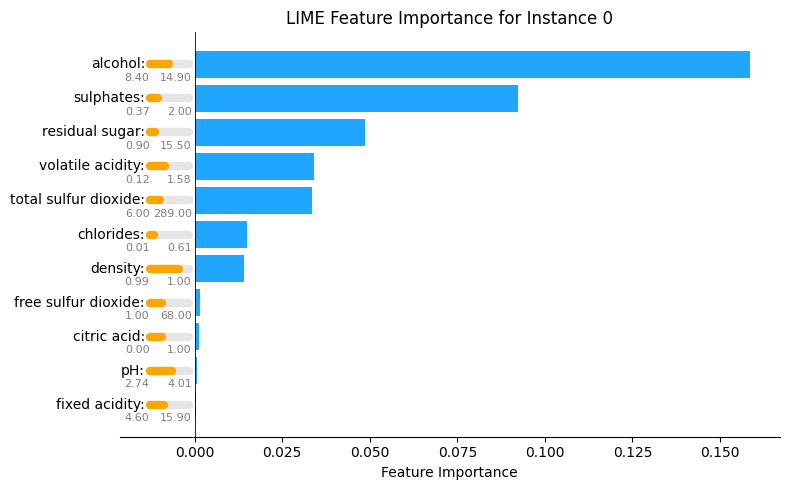

In [8]:
import re

from matplotlib.collections import LineCollection
import random
random_seed = 42
np.random.seed(random_seed)
random.seed(random_seed)

# Select an instance to explain
i = 17  # Choose the instance
instance = X_train.iloc[i]
# Generate explanation
exp = explainer.explain_instance(instance.values, model.predict_proba, num_features=len(X.columns))

# Extract feature importance (absolute values)
exp_dict = dict(exp.as_list())
features = list(exp_dict.keys())
org_importance = [abs(val) for val in exp_dict.values()]
# Convert feature values to strings
original_importance = {feature: abs(val) for feature, val in exp_dict.items()}

instance_str = instance.apply(lambda x: str(x))
original_instance_str = instance.apply(lambda x: str(x))

# Extract feature names and values using regular expressions
features_with_values = []
features_ = []
max_importance = max(importance)
for feature in features:
    match = re.findall(r'([a-zA-Z]+)', feature)
    if match:
        feature_name = ' '.join(match)  # Combine all matches with a space
        feature_value = instance_str[feature_name]
        features_with_values.append(f"{feature_name}={feature_value}")
        features_.append(f"{feature_name}")
    else:
        features_with_values.append(f"{feature}={instance_str[feature]}")

# Step 4: Plot Feature Importance with values
fig, ax1= plt.subplots(figsize=(9, 5))
ax1.set_yticklabels([])
ax1.yaxis.set_ticks([])
ax1.axvline(x=0, color='black',linewidth=0.6)
# Add vertical grid lines
bars = plt.barh(features_with_values, org_importance, color='#20A6FF',zorder=1)

# ax1.set_yticks(range(len(features_with_values)))
plt.xlabel('Feature Importance')
plt.title('LIME Feature Importance for Instance {}'.format(i))
plt.gca().invert_yaxis()
plt.tight_layout()  # Adjust layout to ensure everything fits
plt.subplots_adjust(left=0.25) 
# Custom y-axis labels with min, max, and current values
# Remove chart borders
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
# ax1.spines['bottom'].set_visible(False)
features_with_bound = []
for i, bar in enumerate(bars):
    feature = features_with_values[i]
    feature_name = feature.split('=')[0]
    
    min_val = X_train[feature_name].min()
    max_val = X_train[feature_name].max()
    
    current_val = instance[feature_name]
    features_with_bound.append({'name':feature_name,'range':[min_val,current_val,max_val] })
    # Normalize values to a fixed range (e.g., 0 to 1)
    fixed_min = - max_importance * 0.08
    fixed_max = - max_importance * 0.01
    fixed_current = (current_val - min_val) / (max_val - min_val) * (fixed_max - fixed_min) + fixed_min
    # Draw min-max range bar with fixed length and rounded edges
    line = [(fixed_min, i), (fixed_max, i)]
    line_collection = LineCollection([line], linewidths=6, colors='grey', alpha=0.2, capstyle='round')
    ax1.add_collection(line_collection)
    
    # Draw min-current range bar with deeppink color and fixed length with rounded edges
    line1 = [(fixed_min, i), (fixed_current, i)]
    line_collection1 = LineCollection([line1], linewidths=6, colors='orange', capstyle='round')
    ax1.add_collection(line_collection1)
    ax1.plot([fixed_current, fixed_current], [i - 0.2, i + 0.15], color='deeppink', linewidth=0)
    
    label = f"{feature_name}:"
    ax1.text(fixed_min*1.1, bar.get_y() + bar.get_height()/2, label, va='center', ha='right')
    label = f"{min_val:.2f} | {current_val:.2f} | {max_val:.2f}"
    ax1.text(fixed_min, bar.get_y()+0.4 + bar.get_height()/2, f"{min_val:.2f}", va='center', ha='right', color='gray', fontsize=8)

    ax1.text(fixed_max*0.5, bar.get_y()+0.4 + bar.get_height()/2, f"{max_val:.2f}", va='center', ha='right', color='gray', fontsize=8)

plt.show()

In [13]:
org_importance

[0.158397265933497,
 0.0922532544406984,
 0.048755244249536984,
 0.03402556353348524,
 0.033486373212198016,
 0.014879405146689575,
 0.013969983508873574,
 0.0016906267899112742,
 0.0012063988223649134,
 0.0006252245330771827,
 0.00030226805148565316]

predict [0]


/mnt/ssd2/yifan/miniconda3/envs/llama/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/mnt/ssd2/yifan/miniconda3/envs/llama/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


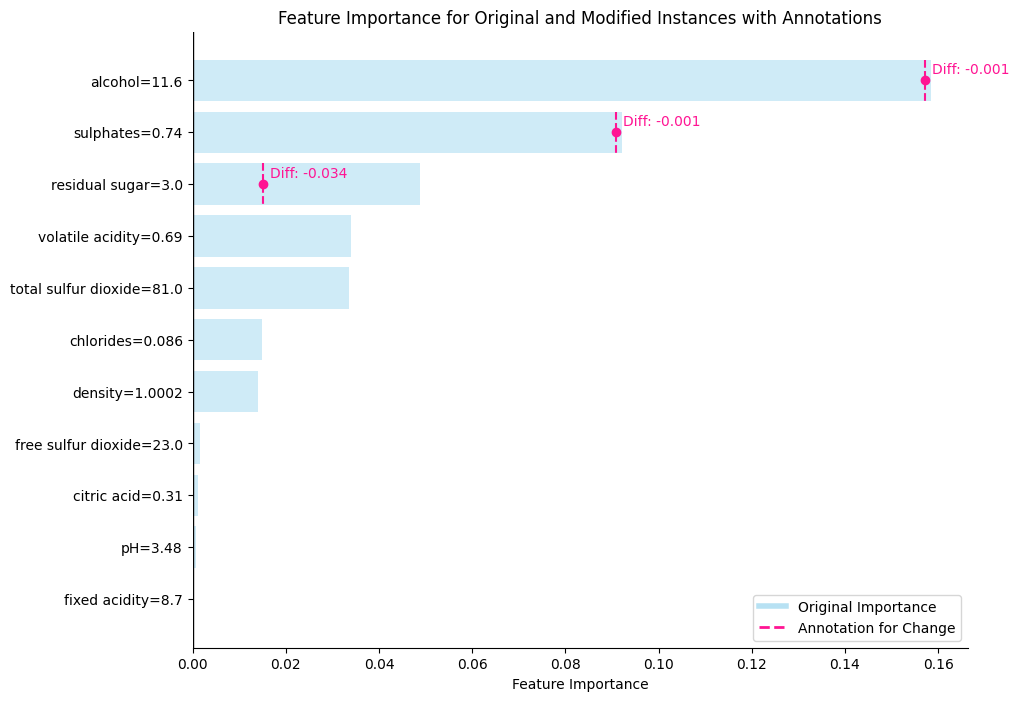

In [12]:
import re

import random
random_seed = 42
np.random.seed(random_seed)
random.seed(random_seed)
# Select an instance to explain
 # Choose the instance
# instance = X_train.iloc[0]

instance = X_train.iloc[0].copy()  # Create a copy of the instance to avoid modifying the original DataFrame
modified_key = 'residual sugar'
modified_value = 0
instance[modified_key] = modified_value
# Change the 'alcohol' value of the instance to 10

predict = model.predict([instance])
print("predict",predict)
# Generate explanation
exp = explainer.explain_instance(instance.values, model.predict_proba, num_features=len(X.columns))

# Extract feature importance (absolute values)
exp_dict = dict(exp.as_list())
features = list(exp_dict.keys())
new_importance = [abs(val) for val in exp_dict.values()]
max_importance = max(new_importance)
# Convert feature values to strings
instance_str = instance.apply(lambda x: str(x))

# Extract feature names and values using regular expressions
modified_features_with_values = []
modified_features = []
for feature in features:
    match = re.findall(r'([a-zA-Z]+)', feature)
    # print("match",feature, match)
    if match:
        feature_name = ' '.join(match)  # Combine all matches with a space
        feature_value = instance_str[feature_name]
        modified_features_with_values.append(f"{feature_name}={feature_value}")
        modified_features.append(f"{feature_name}")
    else:
        modified_features_with_values.append(f"{feature}={instance_str[feature]}")

import matplotlib.pyplot as plt
import random
random_seed = 42
np.random.seed(random_seed)
random.seed(random_seed)
# Create a mapping from modified feature names to their new importance
new_importance_dict = dict(zip(modified_features, new_importance))

# Plot Feature Importance with values
fig, ax = plt.subplots(figsize=(10, 8))
bars = ax.barh(features_with_values, org_importance, color='skyblue',alpha=0.4, label='Original Importance')

# Add a black vertical line at x=0
plt.axvline(x=0, color='black', linewidth=1)

# Annotate bars with the new importance values and changes
for i, (bar, org_value, feature) in enumerate(zip(bars, org_importance, features_)):
    bar_center = bar.get_y() + bar.get_height() / 2
    new_value = new_importance_dict[feature]
    if abs(new_value-org_value)>0.001:
        # print(abs(new_value-org_value))
        ax.plot([new_value], [bar_center], 'o', color='deeppink')  # Plot the new importance as an orange circle
        ax.vlines(new_value, bar_center - bar.get_height() / 2, bar_center + bar.get_height() / 2, colors='deeppink', linestyles='dashed')  # Add a vertical dashed line
        ax.annotate(f"Diff: {new_value-org_value:.3f}", (new_value, bar_center), textcoords="offset points", xytext=(5, 5), ha='left', color='deeppink')

# Add feature values next to the y-axis and on the bars
# for idx, feature in enumerate(features_with_values,):

#     if modified_key in feature:
#         ax.text(-0.01, idx + 0.3, f"{modified_key}={modified_value:.2f}", va='center', ha='right', color='deeppink', fontsize=10, transform=ax.get_yaxis_transform())

plt.xlabel('Feature Importance')
plt.title('Feature Importance for Original and Modified Instances with Annotations')

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='skyblue', lw=4, alpha=0.6),
                Line2D([0], [0], color='deeppink', lw=2, linestyle='--')]
ax.legend(custom_lines, ['Original Importance', 'Annotation for Change'], loc='lower right')

# plt.legend(loc='lower right')
plt.gca().invert_yaxis()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
# ax1.spines['bottom'].set_visible(False)

# for i, bar in enumerate(bars):
#     feature = features_with_values[i]
#     feature_name = feature.split('=')[0]
#     min_val = X_train[feature_name].min()
#     max_val = X_train[feature_name].max()
#     current_val = instance[feature_name]
#     # Normalize values to a fixed range (e.g., 0 to 1)
#     fixed_min = - max_importance * 0.08
#     fixed_max = - max_importance * 0.01
#     fixed_current = (current_val - min_val) / (max_val - min_val) * (fixed_max - fixed_min) + fixed_min
#     # Draw min-max range bar with fixed length and rounded edges
#     line = [(fixed_min, i), (fixed_max, i)]
#     line_collection = LineCollection([line], linewidths=6, colors='grey', alpha=0.5, capstyle='round')
#     ax.add_collection(line_collection)
    
#     # Draw min-current range bar with deeppink color and fixed length with rounded edges
#     line1 = [(fixed_min, i), (fixed_current, i)]
#     line_collection1 = LineCollection([line1], linewidths=6, colors='deeppink', capstyle='round')
#     ax.add_collection(line_collection1)
#     ax.plot([fixed_current, fixed_current], [i - 0.2, i + 0.15], color='deeppink', linewidth=0)
#     # label = f"{feature_name}:{min_val:.2f} | {current_val:.2f} | {max_val:.2f}"
#     label = f"{feature_name}:"
#     ax.text(fixed_min*1.1, bar.get_y() + bar.get_height()/2, label, va='center', ha='right')

plt.show()


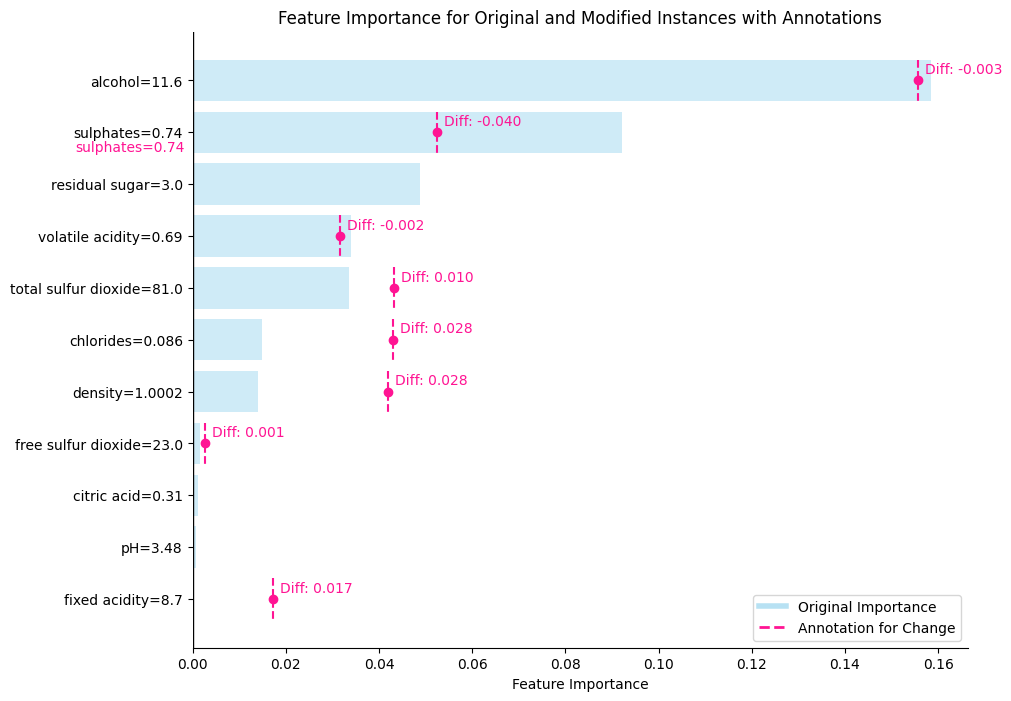

In [40]:
features_with_values

['alcohol=9.6',
 'sulphates=0.66',
 'volatile acidity=0.56',
 'chlorides=0.114',
 'density=0.9971',
 'total sulfur dioxide=46.0',
 'fixed acidity=7.7',
 'pH=3.24',
 'citric acid=0.08',
 'free sulfur dioxide=14.0',
 'residual sugar=2.5']

In [29]:
importance

[0.10068860428294098,
 0.0974183067420677,
 0.0911951333181305,
 0.053578240210516326,
 0.04635885594426909,
 0.019607383930616583,
 0.016166572549849583,
 0.010653853661193374,
 0.00734438545775354,
 0.006109423115477939,
 0.004973674705446921]

In [32]:
features

['sulphates > 0.73',
 'volatile acidity > 0.64',
 '9.50 < alcohol <= 10.20',
 '22.00 < total sulfur dioxide <= 38.00',
 'chlorides > 0.09',
 'density > 1.00',
 '0.10 < citric acid <= 0.26',
 '3.21 < pH <= 3.31',
 '14.00 < free sulfur dioxide <= 21.00',
 'fixed acidity > 9.20',
 'residual sugar > 2.60']